In [94]:
import os
import random

from io import BytesIO 
from pathlib import Path

import boto3
import hashlib
import imagehash

import pandas as pd
import toloka.client as toloka

from PIL import Image, ImageOps

from getpass import getpass
from tqdm.auto import tqdm

from elasticsearch import Elasticsearch

In [2]:
#TOLOKA_TOKEN = os.getenv('TOLOKA_TOKEN')
TOLOKA_TOKEN = getpass()

In [98]:
client = toloka.TolokaClient(TOLOKA_TOKEN, 'PRODUCTION')

Let's submit some tasks to the pool we just created

In [4]:
# replace it with your ids

project_id = 123522 
pool_id = 36759338

In [10]:
for _ in tqdm(range(10)):
    suites = []

    for i in range(10):
        ID = random.randint(1, 50000)
        task = toloka.Task(input_values={'ID': ID})
        suite = toloka.TaskSuite(tasks=[task], pool_id=pool_id, overlap=1)
        suites.append(suite)

    result = client.create_task_suites_async(task_suites=suites)

  0%|          | 0/10 [00:00<?, ?it/s]

Now we can use the SDK to get the data

In [45]:
request = toloka.search_requests.AssignmentSearchRequest(
    status='SUBMITTED',
    pool_id=pool_id,
)

assignments = client.get_assignments(request)

This is how assignments look like: 

In [46]:
a = next(assignments)
print(a.to_json(pretty=True))

{
    "automerged": false,
    "created": "2022-12-09T13:23:29.395000",
    "id": "000230e72a--639336d1c2386c6429d59d9a",
    "mixed": false,
    "owner": {
        "id": "95d080317f8b10da0bf56d6820c24fbe",
        "myself": true
    },
    "pool_id": "36759338",
    "reward": 0.010,
    "solutions": [
        {
            "output_values": {
                "class": "cup",
                "image": "eu.ecc52fea-3af5-4ebf-b139-71c0b41e1676"
            }
        }
    ],
    "status": "SUBMITTED",
    "submitted": "2022-12-09T13:25:22.494000",
    "task_suite_id": "000230e72a--639335aa8bed2528a37cf481",
    "tasks": [
        {
            "id": "9226ebd8-3e13-4745-aff6-dcc8b67f6787",
            "input_values": {
                "ID": 29362
            }
        }
    ],
    "user_id": "ad16da03fd6a34a2711808d4c7ce4992"
}


Let's collect all the data in one list:

In [118]:
assignments = client.get_assignments(request)

image_results = []

for assignment in assignments:
    assignment_id = assignment.id
    for solution in assignment.solutions:
        output_values = solution.output_values
        output_values['assignment_id'] = assignment_id
        image_results.append(output_values)

In [119]:
image_results[-1]

{'class': 'cup',
 'image': 'eu.1d45b56f-961d-4ce3-9338-fc57e37d2784',
 'assignment_id': '000230e72a--63933da5bc4d8318bd5280e7'}

In the "image" column we have the id of the attachment to the task. We need to download them

In [136]:
attachments_dir = Path('attachments') / str(pool_id)
attachments_dir.mkdir(parents=True, exist_ok=True)

In [75]:
def download_attachment(attachments_dir, attachment_id):
    file = attachments_dir / attachment_id

    if file.exists():
        return file

    with file.open('wb') as f_out:
        client.download_attachment(attachment_id, f_out)
    
    return file

In [77]:
image_file = download_attachment(attachments_dir, 'eu.ecc52fea-3af5-4ebf-b139-71c0b41e1676')

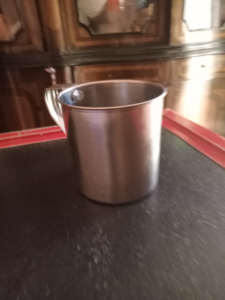

In [83]:
image = Image.open(image_file)
image.thumbnail((300, 300), resample=Image.Resampling.BILINEAR)
image

To remove duplicates, we will calculate hashes of images and then use elasticsearch to store them.

In [92]:
def calculate_phashes(image_stream):
    img = Image.open(image_stream)

    dhash = str(imagehash.dhash(img))
    phash = str(imagehash.phash(img))
    whash = str(imagehash.whash(img))

    return {
        "dhash": dhash,
        "phash": phash,
        "whash": whash,
    }


def calculate_hashes(image_bytes):
    stream = BytesIO(image_bytes)
    hashes = calculate_phashes(stream)

    md5 = hashlib.md5(image_bytes).hexdigest()
    hashes["md5"] = md5

    return hashes


def read_and_calculate_hashes(filename):
    with open(filename, 'rb') as f_in:
        content = f_in.read()
        hashes = calculate_hashes(content)
        return hashes

In [93]:
read_and_calculate_hashes(image_file)

{'dhash': '526fceed3d3fffff',
 'phash': 'a5a56d78da91858d',
 'whash': '3b233f7f17070303',
 'md5': '2da3441cb3fb8d31680c7a178587d744'}

Now let's run Elastic in Docker:

```
docker run -it \
    -p 9200:9200 \
    -p 9300:9300 \
    -v es_toloka_worskhop_data:/usr/share/elasticsearch/data \
    -e "discovery.type=single-node" \
    -e ELASTIC_PASSWORD="changeme" \
    docker.elastic.co/elasticsearch/elasticsearch:8.5.0
```

And connect to it using username "elastic" and password "changeme" 

In [102]:
es_client = Elasticsearch("http://localhost:9200", basic_auth=('elastic', 'changeme'))
es_client.info()

ObjectApiResponse({'name': '766f46b1ddfd', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'MsWIqqQZRzuvFrZ5Er9QHA', 'version': {'number': '8.5.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': 'c94b4700cda13820dad5aa74fae6db185ca5c304', 'build_date': '2022-10-24T16:54:16.433628434Z', 'build_snapshot': False, 'lucene_version': '9.4.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

Create an index:

In [117]:
index_exists = es_client.indices.exists(index='attachment')

if not index_exists.body:
    attachment_schema = {
        "settings": {"number_of_shards": 1},
        "mappings": {            
            "properties": {
                "md5": {"type": "keyword"},
                "phash": {"type": "keyword"},
                "dhash": {"type": "keyword"},
                "whash": {"type": "keyword"},
            }
        },
    }

    es_client.indices.create(index='attachment', body=attachment_schema)

Let's define a few helper functions to communicate with elastic - to check if hashes exist and to save new hashes:

In [123]:
def save_hashes(attachment_id, hashes):
    es_client.index(index="attachment", id=attachment_id, document=hashes)

def find_duplicates(hashes):
    keys = ['dhash', 'phash', 'md5']
    should = [{"term": {k: hashes[k]}} for k in keys]
    query = {'bool': {'should': should}}

    response = es_client.search(query=query, index='attachment')
    return response['hits']

def has_duplicates(hashes):
    response = find_duplicates(hashes)
    return len(response['hits']) > 0

Now we can iterate over image results, reject submissions marked as "other" and reject duplicates 

In [122]:
image_results[0]

{'class': 'cup',
 'image': 'eu.ecc52fea-3af5-4ebf-b139-71c0b41e1676',
 'assignment_id': '000230e72a--639336d1c2386c6429d59d9a'}

In [125]:
filtered_results = []

for image_submission in tqdm(image_results):
    assignment_id = image_submission['assignment_id']
    attachment_id = image_submission['image']
    
    if image_sumission['class'] == 'other':
        print(f'rejecting {assignment_id} as wrong class...')
        client.reject_assignment(
            assignment_id=assignment_id,
            public_comment='Wrong class, we need only cups, glasses, plates, spoons, forks or knives'
        )
        continue
    
    image_file = download_attachment(attachments_dir, attachment_id)
    hashes = read_and_calculate_hashes(image_file)
    
    if has_duplicates(hashes):
        print(f'rejecting {assignment_id} as duplicate...')
        client.reject_assignment(
            assignment_id=assignment_id,
            public_comment='Duplicate of another submission'
        )
        continue
    
    save_hashes(attachment_id, hashes)
    filtered_results.append(image_submission)

  0%|          | 0/116 [00:00<?, ?it/s]

Let'sprepare data for uploading it for verification. We'll need to upload the images to s3 (and resize before that)

In [140]:
def make_thumbnail(raw_dir, thumbnails_dir, attachment_id):
    filename = raw_dir / attachment_id
    output = thumbnails_dir / (attachment_id + '.jpg')

    with Image.open(filename) as image:
        image = ImageOps.exif_transpose(image)
        image.thumbnail((1000, 1000), resample=Image.Resampling.BILINEAR)

        if image.mode != 'RGB':
            image = image.convert('RGB')

        image.save(output, format='jpeg', quality=95)
    
    return output

In [159]:
s3 = boto3.client('s3')

In [162]:
def upload_thumbnail_to_s3(thumbnail, bucket):
    key = '/'.join(thumbnail.parts[1:])
    
    s3.upload_file(
        Filename=str(thumbnail),
        Bucket=bucket,
        Key=key
    )

    image_url = f'https://{bucket}.s3.eu-west-1.amazonaws.com/{key}'
    return image_url

In [141]:
thumbnails_dir = Path('thumbnails') / str(pool_id)
thumbnails_dir.mkdir(parents=True, exist_ok=True)

In [147]:
thumbnail = make_thumbnail(
    raw_dir=attachments_dir,
    thumbnails_dir=thumbnails_dir,
    attachment_id='eu.3eed5ad4-be40-4062-9d4b-98140384ca61'
)

In [163]:
upload_thumbnail_to_s3(thumbnail, 'toloka-kitchenware')

'https://toloka-kitchenware.s3.eu-west-1.amazonaws.com/36759338/eu.3eed5ad4-be40-4062-9d4b-98140384ca61.jpg'

In [164]:
filtered_results[0]

{'class': 'cup',
 'image': 'eu.ecc52fea-3af5-4ebf-b139-71c0b41e1676',
 'assignment_id': '000230e72a--639336d1c2386c6429d59d9a',
 'image_file': WindowsPath('attachments/36759338/eu.ecc52fea-3af5-4ebf-b139-71c0b41e1676')}

In [167]:
for image_submission in tqdm(filtered_results):
    attachment_id = image_submission['image']
    
    thumbnail = make_thumbnail(
        raw_dir=attachments_dir,
        thumbnails_dir=thumbnails_dir,
        attachment_id=attachment_id
    )

    url = upload_thumbnail_to_s3(thumbnail, 'toloka-kitchenware')
    image_submission['image_url'] = url

  0%|          | 0/115 [00:00<?, ?it/s]

We also need to prepare the data in the right format. In our case, we just need to rename “image” to “attachment_id”:

In [172]:
results_for_submission = []

for in_record in filtered_results:
    out_record = {
        'attachment_id': in_record['image'],
        'image_url': in_record['image_url'],
        'assignment_id': in_record['assignment_id']
    }
    
    results_for_submission.append(out_record)

We're ready now to submit it to Toloka. We will display multiple tasks in one assignment,
and for that we will need to chunk the records into batches of 10:

In [173]:
def make_batches(seq, n):
    result = []
    for i in range(0, len(seq), n):
        batch = seq[i:i+n]
        result.append(batch)
    return result

In [174]:
batches = make_batches(results_for_submission, 10)

In [176]:
validate_pool_id = 36830747

In [177]:
suites = []

for batch in tqdm(batches):
    tasks = []
    for input_values in batch:
        task = toloka.Task(input_values=input_values)
        tasks.append(task)

    suite = toloka.TaskSuite(tasks=tasks, pool_id=validate_pool_id, overlap=5)
    suites.append(suite)
    
result = client.create_task_suites_async(task_suites=suites)

Now let's wait till we get the data

In [179]:
verification_request = toloka.search_requests.AssignmentSearchRequest(
    status='ACCEPTED',
    pool_id=validate_pool_id,
)

verification_assignments = client.get_assignments(verification_request)

In [180]:
a = next(verification_assignments)
print(a.to_json(pretty=True))

{
    "accepted": "2022-12-13T22:11:21.620000",
    "automerged": false,
    "created": "2022-12-13T22:09:59.151000",
    "id": "000231fe1b--6398f837fe1d6928f63533a0",
    "mixed": false,
    "owner": {
        "id": "95d080317f8b10da0bf56d6820c24fbe",
        "myself": true
    },
    "pool_id": "36830747",
    "reward": 0.010,
    "solutions": [
        {
            "output_values": {
                "class": "plate",
                "verdict": "yes"
            }
        },
        {
            "output_values": {
                "class": "glass",
                "verdict": "yes"
            }
        },
        {
            "output_values": {
                "class": "glass",
                "verdict": "yes"
            }
        },
        {
            "output_values": {
                "class": "glass",
                "verdict": "yes"
            }
        },
        {
            "output_values": {
                "class": "knife",
                "verdict": "yes"
          

In [182]:
verification_results = []

for assignment in tqdm(verification_assignments):

    for task, solution in zip(assignment.tasks, assignment.solutions):
        input_values = task.input_values
        output_values = solution.output_values
        
        row = input_values.copy()
        row.update(output_values)

        verification_results.append(row)

0it [00:00, ?it/s]

In [190]:
df_verification_results = pd.DataFrame(verification_results)
df_verification_results.head()

,attachment_id,image_url,assignment_id,verdict,class
0,eu.a2df2f74-b646-4897-ad06-fefa0e5997ad,https://toloka-kitchenware.s3.eu-west-1.amazon...,000230e72a--639337e6813eca23060e90a9,yes,plate
1,eu.df4bc224-2e34-4108-b7d7-73675e6f36db,https://toloka-kitchenware.s3.eu-west-1.amazon...,000230e72a--639337f1e2e3ad10120e1d61,yes,plate
2,eu.aa3e03e4-df90-49b6-bcda-991761f87083,https://toloka-kitchenware.s3.eu-west-1.amazon...,000230e72a--639337f69683057bcb25aa50,yes,plate
3,eu.e347b362-5569-4a62-86ec-066ade0a6a33,https://toloka-kitchenware.s3.eu-west-1.amazon...,000230e72a--639337ffe0c3d31f5ddb46ef,yes,plate
4,eu.d03bc751-c625-4089-9d42-7340fabcf446,https://toloka-kitchenware.s3.eu-west-1.amazon...,000230e72a--63933803d836fb07bb1f628f,yes,knife


In [191]:
df_verification_results.verdict.value_counts()

yes                   446
no-multiple-items      35
no-not-kitchenware     30
no-internet            17
no-other               16
no-screenshot          11
Name: verdict, dtype: int64

In [192]:
df_verification_results['class'].value_counts()

cup      110
plate    102
other     82
spoon     79
glass     74
knife     57
fork      51
Name: class, dtype: int64

In [194]:
from collections import Counter

In [196]:
all_results = []

for assignment_id, df_group in df_verification_results.groupby('assignment_id'):
    classes = Counter(df_group['class'])
    verdicts = Counter(df_group['verdict'])
    
    most_common_verdict, _ = verdicts.most_common(1)[0]
    most_common_class, num_votes = classes.most_common(1)[0]

    agreement = num_votes / len(df_group)

    record = {
        'assignment_id': assignment_id,
        'agreement': agreement,
        'image': df_group.iloc[0].image_url,
        'image_id': df_group.iloc[0].attachment_id,
        'most_common_class': most_common_class,
        'most_common_verdict': most_common_verdict,
        'verdicts': verdicts,
        'classes': classes,
    }
    
    all_results.append(record)

df_results = pd.DataFrame(all_results)

In [197]:
df_results.head()

,assignment_id,agreement,image,image_id,most_common_class,most_common_verdict,verdicts,classes
0,000230e72a--639336d1c2386c6429d59d9a,0.8,https://toloka-kitchenware.s3.eu-west-1.amazon...,eu.ecc52fea-3af5-4ebf-b139-71c0b41e1676,cup,yes,{'yes': 5},"{'cup': 4, 'plate': 1}"
1,000230e72a--639336d8d836fb07bb1f50e6,0.8,https://toloka-kitchenware.s3.eu-west-1.amazon...,eu.f3a7f8ec-8ada-4920-9754-2f8f3ea8dd51,cup,yes,{'yes': 5},"{'cup': 4, 'plate': 1}"
2,000230e72a--6393370995e6ae649ea892ce,0.8,https://toloka-kitchenware.s3.eu-west-1.amazon...,eu.b71d59f3-c426-4d98-ad80-acc97c8da685,other,no-internet,"{'no-multiple-items': 1, 'yes': 1, 'no-interne...","{'other': 4, 'plate': 1}"
3,000230e72a--63933719e2e3ad10120e1486,0.8,https://toloka-kitchenware.s3.eu-west-1.amazon...,eu.8f89e771-907c-445d-961b-b32d9b602b81,cup,yes,{'yes': 5},"{'cup': 4, 'plate': 1}"
4,000230e72a--6393372807cdb24305d91a11,0.6,https://toloka-kitchenware.s3.eu-west-1.amazon...,eu.cf51f6c2-f4a1-4bde-acb7-1cb6d8a2eefd,fork,yes,{'yes': 5},"{'fork': 3, 'glass': 1, 'spoon': 1}"


In [198]:
good = (df_results.most_common_verdict == 'yes') & \
    (df_results.most_common_class != 'other') & \
    (df_results.agreement >= 0.5)

In [204]:
df_results['accept'] = good
df_results.accept.mean()

0.7304347826086957

In [208]:
df_final = df_results[df_results.accept][['image', 'most_common_class']]
df_final = df_final.rename(columns={'image': 'image_url', 'most_common_class': 'class'})
df_final.head()

,image_url,class
0,https://toloka-kitchenware.s3.eu-west-1.amazon...,cup
1,https://toloka-kitchenware.s3.eu-west-1.amazon...,cup
3,https://toloka-kitchenware.s3.eu-west-1.amazon...,cup
4,https://toloka-kitchenware.s3.eu-west-1.amazon...,fork
5,https://toloka-kitchenware.s3.eu-west-1.amazon...,cup


In [209]:
df_final.to_csv('data-2022-12-14.csv', index=False)